Load data

In [ ]:
# Mount GDrive to load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [ ]:

# Install extra lib
!pip install xgboost
!pip install imbalanced-learn
!pip install --upgrade scikit-learn

from imblearn.over_sampling import SMOTE

In [ ]:
# Read CSV file
df_loan = pd.read_csv('/content/drive/MyDrive/traluong/loan_data.csv')
df_loan.info()
df_loan.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37066 entries, 0 to 37065
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      37066 non-null  int64  
 1   purpose            37066 non-null  object 
 2   int_rate           37066 non-null  float64
 3   installment        37066 non-null  float64
 4   log_annual_inc     37066 non-null  float64
 5   dti                36966 non-null  float64
 6   fico               37066 non-null  int64  
 7   days_with_cr_line  37066 non-null  int64  
 8   revol_bal          37066 non-null  int64  
 9   revol_util         37054 non-null  float64
 10  inq_last_6mths     37066 non-null  int64  
 11  delinq_2yrs        37032 non-null  float64
 12  pub_rec            37066 non-null  int64  
 13  not_fully_paid     37066 non-null  int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 4.0+ MB


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,credit_card,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0
1,1,home_improvement,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0
2,1,credit_card,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0
3,1,credit_card,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0
4,1,debt_consolidation,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1


EDA DỮ LIỆU


In [ ]:
# Kiểm tra số lượng bản ghi -> 37K bản ghi
df_loan.count()

credit_policy        37066
purpose              37066
int_rate             37066
installment          37066
log_annual_inc       37066
dti                  36966
fico                 37066
days_with_cr_line    37066
revol_bal            37066
revol_util           37054
inq_last_6mths       37066
delinq_2yrs          37032
pub_rec              37066
not_fully_paid       37066
dtype: int64

In [ ]:
# Check for nan record. Only 146 record -> dropna
df_loan[df_loan.isna().any(axis=1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
251,1,credit_card,0.143,1201.33,0.0,NaN,679,42156,16858,0.371,1,0.000,2,1
1554,1,credit_card,0.088,826.66,0.0,NaN,709,38353,47472,0.682,1,0.000,0,0
1805,1,debt_consolidation,0.124,167.03,38000.0,5.56,689,39052,0,NaN,0,0.000,0,0
2226,1,home_improvement,0.082,814.70,120000.0,9.25,764,37987,0,NaN,0,0.000,0,0
2345,1,debt_consolidation,0.131,797.80,0.0,NaN,814,37316,97,0.016,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35967,1,house,0.082,1256.97,0.0,NaN,709,31686,0,0.000,278568,0.544,0,1
35969,1,home_improvement,0.139,928.66,1.0,NaN,709,33848,0,0.000,1648,0.323,0,1
36356,1,debt_consolidation,0.250,59.64,60000.0,9.40,719,39234,0,0.000,0,NaN,0,1
36503,1,credit_card,0.065,1225.24,0.0,NaN,739,30864,0,0.000,55481,0.937,0,1


In [ ]:
# Drop all Nan rows
df_loan.dropna(inplace=True)

In [ ]:
# Check for nan record. Only 146 record -> no record
df_loan[df_loan.isna().any(axis=1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid


1    26775
0    10145
Name: not_fully_paid, dtype: int64


<Axes: >

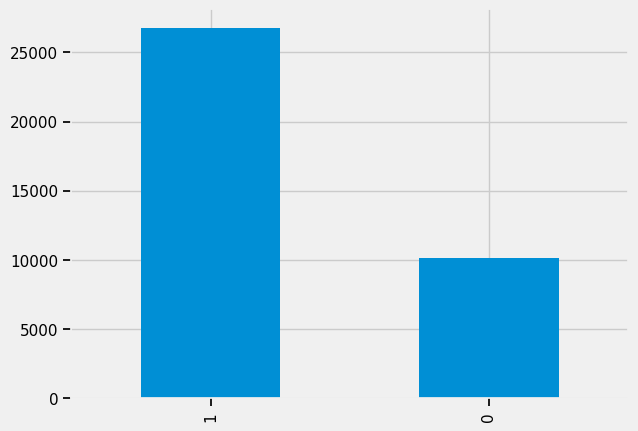

In [ ]:
# Thống kê khoản vay có hoàn trả hay không.
  # 0: khoản vay không được hoàn trả dầy đủ
  # 1: khoản vay được hoàn trả đày đủ

print(df_loan["not_fully_paid"].value_counts())
df_loan["not_fully_paid"].value_counts().plot(kind="bar")

# Dữ liệu imbalance nặng -> cần xử lý -> sẽ xử lý sau

In [ ]:
# Tìm các field là Object/ String -> chỉ có cột Purpose -> Xử lý cột này bằng OneHot
object_cols = [f for f in df_loan.columns if df_loan[f].dtype =="O"]
print(object_cols)

['purpose']


In [ ]:
# Tìm hiểu qua về cột này
df_loan['purpose'].value_counts()

# Dễ thấy đa số là debt_consolidation -> Có 2 cách
# - Để nguyên và thực hiện onehot
# - Gom lại debt_cosolidation và Others
# -> Mình sẽ thử cách 2

debt_consolidation    19516
credit_card            9087
home_improvement       2836
other                  2496
major_purchase          899
medical                 465
house                   406
car                     384
vacation                313
small_business          269
moving                  234
renewable_energy         15
Name: purpose, dtype: int64

In [ ]:
# Định nghĩa hàm để xử lý mục đích
def process_purpose(x):
  # Nếu mục đích là "debt_consolidation", gán giá trị 1
  if x == "debt_consolidation":
    return 1
  # Ngược lại, gán giá trị 0
  else:
    return 0

# Áp dụng hàm xử lý mục đích vào cột 'purpose' và tạo cột mới 'purpose_int'
df_loan['purpose_int'] = df_loan['purpose'].apply(process_purpose)


In [ ]:
df_loan['purpose_int'].value_counts() # -> chỉ còn 2 giá trị

1    19516
0    17404
Name: purpose_int, dtype: int64

In [ ]:
# Drop purpose và view lại
df_loan.drop(columns=["purpose"], inplace=True)
df_loan.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,1,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,1,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,1,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,1,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [ ]:
# Check cột credit_policy -> toàn 1 -> drop
df_loan["credit_policy"].value_counts()

1    36920
Name: credit_policy, dtype: int64

100% là 1 ảnh hưởng đến việc train model

In [ ]:
# Drop credit_policy và view lại
df_loan.drop(columns=["credit_policy"], inplace=True)
df_loan

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.000,0,0,0
1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.000,0,0,0
2,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.000,0,0,0
3,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.000,0,0,0
4,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37061,0.088,792.79,167000.0,24.66,694,37895,0,0.000,25987,0.680,0,1,1
37062,0.103,856.40,125000.0,11.73,744,31444,0,0.000,1728,0.033,0,1,1
37063,0.180,837.45,75000.0,9.02,694,40878,3,0.000,636,0.038,0,1,0
37064,0.110,458.48,32072.0,58.12,779,39539,0,0.000,15016,0.289,0,1,1


In [ ]:
# Check Corr để xem có bỏ field nào đi không? -> ko thấy 2 cột input nào quá corr -> giữ lại toàn bộ input.(kiểm tra in put đầu vào)
corr = df_loan.corr()
corr.style.background_gradient(cmap='coolwarm')

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
int_rate,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599,0.097478
installment,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016,0.140044
log_annual_inc,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026,-0.002927
dti,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361,0.054696
fico,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124,-0.024893
days_with_cr_line,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029,-0.006357
revol_bal,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469,0.029699
revol_util,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816,0.004182
inq_last_6mths,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629,-0.007000
delinq_2yrs,0.172759,0.046695,0.029868,0.032497,-0.307689,-0.052515,-0.146972,-0.014098,0.220876,1.000000,-0.030163,0.135084,0.007397


<ipython-input-23-2320a6472fe4>:16: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


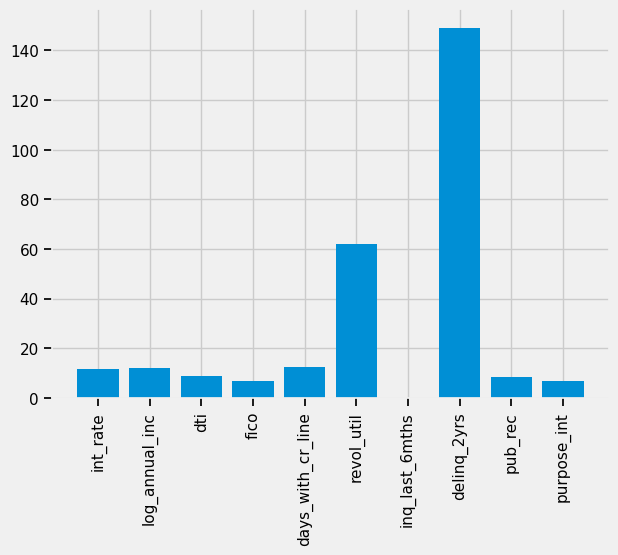

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

# Giả sử bạn đã có một DataFrame có tên là df_loan
# df_loan = pd.read_csv("duong_dan_den_file.csv")  # Thay đổi đường dẫn nếu cần

# Đảm bảo DataFrame df_loan đã được định nghĩa trước khi sử dụng
predictors = df_loan.drop(columns=["not_fully_paid"]).columns.values

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(df_loan[predictors], df_loan["not_fully_paid"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores, excluding "installment", "revol_bal", and "inq_last_6MONTHS"
selected_predictors = [col for col in predictors if col not in ["installment", "revol_bal", "inq_last_6MONTHS"]]
selected_scores = [score for col, score in zip(predictors, scores) if col not in ["installment", "revol_bal", "inq_last_6MONTHS"]]

plt.bar(range(len(selected_predictors)), selected_scores)
plt.xticks(range(len(selected_predictors)), selected_predictors, rotation='vertical')
plt.show()


In [ ]:
# Scale dữ liệu
X = df_loan[predictors]
y = df_loan["not_fully_paid"]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X[predictors])
X[predictors] = scaler.transform(X[predictors])

X

<ipython-input-24-719d5fe2eddb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[predictors] = scaler.transform(X[predictors])


,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_int
0,0.352941,0.285030,0.016129,0.015716,0.161290,0.760027,0.039118,0.029304,0.000005,0.333333,0.0,0.0
1,0.223529,0.511634,0.005914,0.030160,0.376344,0.666667,0.023568,0.020696,0.000003,0.066667,0.0,0.0
2,0.137255,0.459866,0.017742,0.016126,0.161290,0.687403,0.040966,0.024652,0.000000,0.000000,0.0,0.0
3,0.458824,0.155066,0.004301,0.032102,0.430108,0.877044,0.016865,0.009826,0.000003,0.000000,0.0,0.0
4,0.137255,0.329176,0.003871,0.023754,0.268817,0.794100,0.014965,0.011130,0.000002,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37061,0.137255,0.464417,0.017957,0.024685,0.161290,0.761488,0.000000,0.000000,0.039809,0.045333,0.0,1.0
37062,0.196078,0.503171,0.013441,0.011742,0.430108,0.447479,0.000000,0.000000,0.002647,0.002200,0.0,1.0
37063,0.498039,0.491626,0.008065,0.009029,0.161290,0.906688,0.000006,0.000000,0.000974,0.002533,0.0,0.0
37064,0.223529,0.260740,0.003449,0.058178,0.618280,0.841511,0.000000,0.000000,0.023003,0.019267,0.0,1.0


In [ ]:
# Split dữ liệu train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Hiển thị thử X_train
X_train.head()


,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_int
24635,0.729412,0.505840,0.013441,0.017107,0.053763,0.697771,0.000000,0.086957,0.018102,0.051333,0.2,1.0
22808,0.266667,0.386884,0.009247,0.003403,0.403226,0.705218,0.000002,0.000000,0.017255,0.043933,0.0,0.0
16378,0.400000,0.236607,0.004839,0.017828,0.080645,0.848958,0.000000,0.000000,0.012404,0.046133,0.0,1.0
25975,0.266667,0.144526,0.005376,0.016697,0.188172,0.832603,0.000006,0.000000,0.014905,0.028933,0.0,0.0
16426,0.086275,0.246575,0.017742,0.004795,0.456989,0.813376,0.000000,0.000000,0.005965,0.011467,0.2,0.0


Train 01. Upsampling bằng SMOTE, train Logistic Regression

In [ ]:
# Upsampling
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train,y_train)


In [ ]:
# Check xem balance chưa
y_train_resample.value_counts()

1    21484
0    21484
Name: not_fully_paid, dtype: int64

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
pip install seaborn


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},


              precision    recall  f1-score   support

           0       0.69      0.68      0.68      2093
           1       0.87      0.88      0.88      5291

    accuracy                           0.82      7384
   macro avg       0.78      0.78      0.78      7384
weighted avg       0.82      0.82      0.82      7384



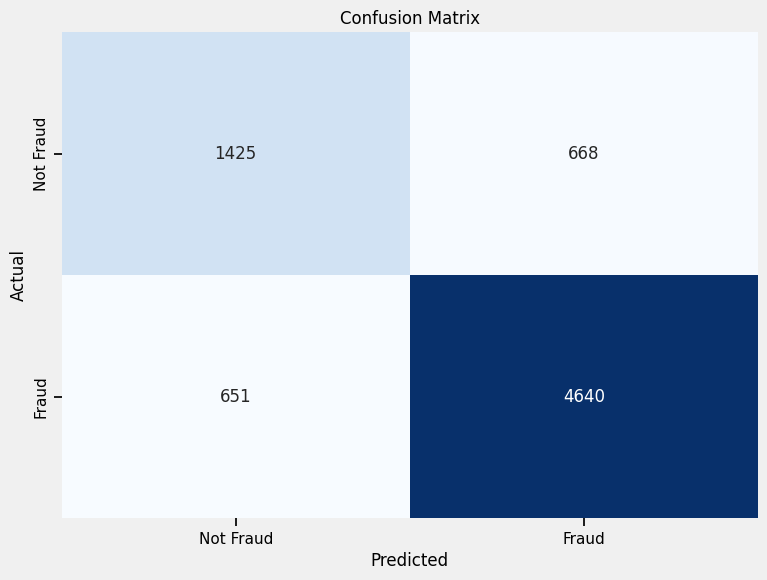

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search tìm tham số
params_grid_logistic={"C":[0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1", "l2"]}# l1 lasso l2 ridge

grid_logistic= GridSearchCV( LogisticRegression(solver='lbfgs', max_iter=1000) ,params_grid_logistic, cv=10)
grid_logistic.fit(X_train_resample, y_train_resample)

print("tuned hpyerparameters :(best parameters) ",grid_logistic.best_params_)
print('\033[1m' + "accuracy :",grid_logistic.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    "error_score must be the string 'raise' or a numeric value. "
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    self
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    # TODO(1.4): Remove "none" option
ValueError: Solver lbfgs supports only '

tuned hpyerparameters :(best parameters)  {'C': 1000, 'penalty': 'l2'}
accuracy : 0.7938702741378183


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2093
           1       0.87      0.90      0.89      5291

    accuracy                           0.83      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.83      0.83      7384



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},


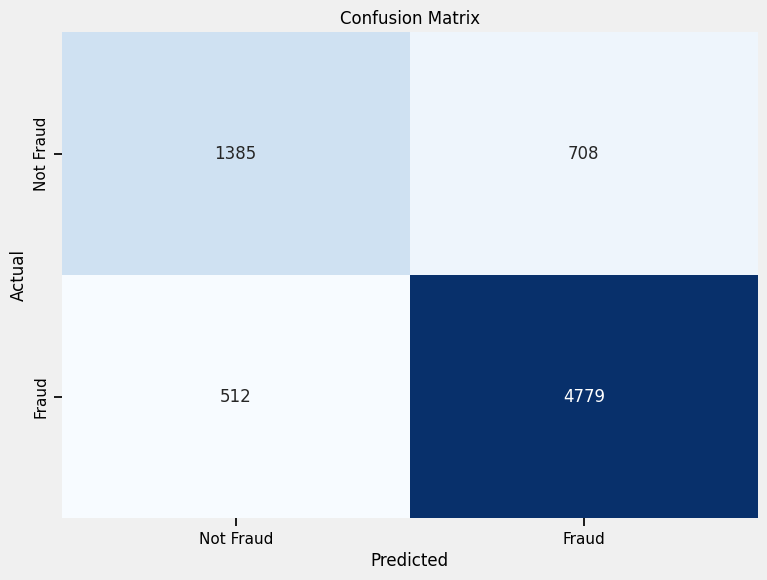

In [ ]:
# Grid Search Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_logistic = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_logistic.fit(X_train_resample, y_train_resample)

# Make predictions
y_pred = grid_logistic.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Train 2. Không upsampling. XGBoost

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2093
           1       0.87      0.91      0.89      5291

    accuracy                           0.83      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.83      0.83      7384



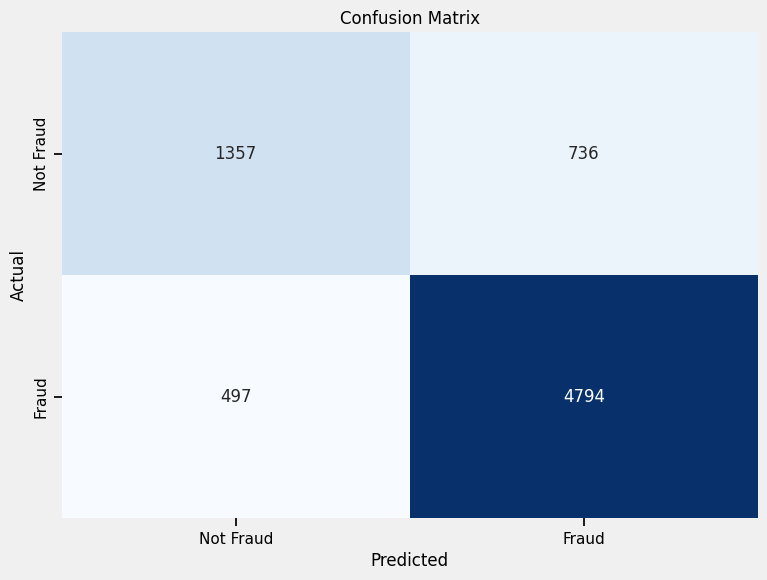

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

# In bao cao ket qua
print(classification_report( y_test, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

0.77721


<ipython-input-50-0032ea0593ef>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--', color="navy")


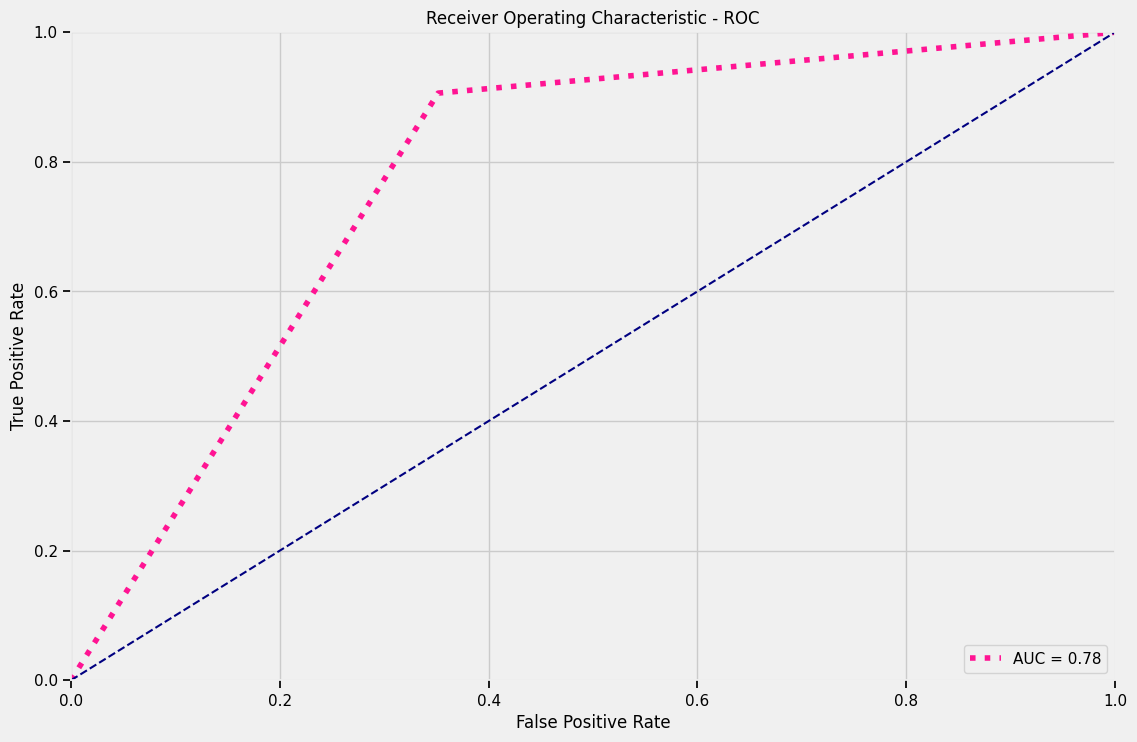

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict

fpr_log_ros, tpr_log_ros, thresholds_log_ros = roc_curve(y_test, y_pred)

auc_log_ros = float("{:.5f}".format(auc(fpr_log_ros, tpr_log_ros)))
print(auc_log_ros)

plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic - ROC')
plt.plot(fpr_log_ros, tpr_log_ros, ':', linewidth=4, label = 'AUC = %0.2f' % auc_log_ros, color="deeppink", )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--', color="navy")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:

#Grid search XGBoost
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 2),
    'n_estimators': range(60, 220, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}


In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=160, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Grid search XGBoost
estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range(2, 10, 2),
    'n_estimators': range(60, 220, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='roc_auc',
    n_jobs=10,
    cv=10,
    verbose=True
)

grid_search.fit(X_train, y_train)

# Trích xuất các siêu tham số tốt nhất
best_params = grid_search.best_params_

# Tạo một XGBClassifier mới với các siêu tham số tốt nhất
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=42,
    **best_params
)

print("Các Siêu Tham Số Tốt Nhất:", best_params)
print("Mô Hình Tốt Nhất:", best_model)


Fitting 10 folds for each of 24 candidates, totalling 240 fits
Các Siêu Tham Số Tốt Nhất: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 160}
Mô Hình Tốt Nhất: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=160, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)


In [ ]:
import pickle

# Đặt tên cho file lưu trữ mô hình
model_filename = 'best_model_xgboost.pkl'

# Lưu mô hình vào file
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

# Tải lại mô hình từ file
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)


In [ ]:
model_filename = '/content/drive/MyDrive/traluong/best_model_xgboost.pkl'

# Lưu mô hình vào Google Drive
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)